## Import

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Import Tensorflow

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

## Setup with Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
# Définir le chemin où se trouve ton fichier ZIP
# Remplace 'brain_tumor_project' par le nom du dossier que tu as créé
ZIP_PATH = '/content/drive/MyDrive/brain-tumor-detection-project/kaggle_3m.zip'

# Définir le répertoire de destination (le dossier temporaire de Colab)
DEST_PATH = '/content/data/'
os.makedirs(DEST_PATH, exist_ok=True)

# Dézipper le fichier (commande Linux exécutée dans Colab)
!unzip -q "{ZIP_PATH}" -d "{DEST_PATH}"
print("✅ Décompression terminée.")

# Définir le nouveau chemin racine des données
DATA_DIR = os.path.join(DEST_PATH, 'kaggle_3m')

# Vérification : Doit imprimer le chemin vers un patient
print(f"Nouveau chemin racine des données : {DATA_DIR}")

replace /content/data/__MACOSX/._kaggle_3m? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
✅ Décompression terminée.
Nouveau chemin racine des données : /content/data/kaggle_3m


In [6]:
# 1. Rappel du chemin que tu utilises actuellement
print(f"👉 Ton chemin DATA_DIR actuel est : {DATA_DIR}")

# 2. Vérification d'existence
if not os.path.exists(DATA_DIR):
    print("❌ ERREUR FATALE : Ce dossier n'existe pas ! Le chemin est faux.")
else:
    print("✅ Le dossier racine existe. Regardons ce qu'il y a dedans...")

    # 3. Lister le contenu direct
    contenu = os.listdir(DATA_DIR)
    print(f"📂 Contenu trouvé ({len(contenu)} éléments) :")
    print(contenu[:10]) # On affiche les 10 premiers

    # 4. Vérification du piège classique ("Dossier dans un dossier")
    # Souvent, le dézippage crée un sous-dossier supplémentaire
    if 'kaggle_3m' in contenu:
        print("\n⚠️ ALERTE : Je vois un dossier 'kaggle_3m' À L'INTÉRIEUR de ton dossier.")
        print("💡 SOLUTION : Ton chemin s'arrête trop tôt.")
        print(f"Essaie de changer DATA_DIR en : {os.path.join(DATA_DIR, 'kaggle_3m')}")

👉 Ton chemin DATA_DIR actuel est : /content/data/kaggle_3m
✅ Le dossier racine existe. Regardons ce qu'il y a dedans...
📂 Contenu trouvé (112 éléments) :
['TCGA_HT_7884_19980913', 'TCGA_DU_A5TW_19980228', 'TCGA_CS_6666_20011109', 'TCGA_HT_7693_19950520', 'TCGA_DU_7300_19910814', 'TCGA_HT_7605_19950916', 'TCGA_DU_5852_19950709', 'TCGA_DU_6404_19850629', 'TCGA_HT_8105_19980826', 'TCGA_DU_A5TY_19970709']


## Setup in local

In [4]:
# Bien penser à remplacer le chmin vers la source de données
DATA_DIR = '/Users/victor/code/afallo/brain_tumor_detection_project/raw_data/segmentation/kaggle_3m'

## DF + Balancing des classes

In [5]:
def create_diagnosed_dataframe(data_dir):
    data = []

    print("🕵️‍♂️ Analyse et vérification des fichiers en cours...")

    for dirname, _, filenames in os.walk(data_dir):
        for filename in filenames:
            if 'mask' in filename and filename.endswith('.tif'):

                mask_path = os.path.join(dirname, filename)
                image_filename = filename.replace('_mask', '')
                image_path = os.path.join(dirname, image_filename)

                # 1. Vérification d'intégrité : L'image source existe-t-elle ?
                if os.path.exists(image_path):

                    # 2. Vérification de contenu : Le masque est-il vide ?
                    # On lit le masque en niveau de gris (0 = noir, 255 = blanc)
                    try:
                        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                        # Si la valeur max est > 0, c'est qu'il y a une tumeur (du blanc)
                        has_tumor = 1 if np.max(mask_img) > 0 else 0

                        data.append({
                            'image_path': image_path,
                            'mask_path': mask_path,
                            'has_tumor': has_tumor
                        })
                    except Exception as e:
                        print(f"⚠️ Fichier corrompu ignoré : {filename} ({e})")

    df = pd.DataFrame(data)
    return df

# Exécution
df = create_diagnosed_dataframe(DATA_DIR)

🕵️‍♂️ Analyse et vérification des fichiers en cours...


In [6]:
def balance_dataset(df):
    # 1. On sépare les deux groupes
    df_tumor = df[df['has_tumor'] == 1]
    df_healthy = df[df['has_tumor'] == 0]

    print(f"Original -> Tumeurs: {len(df_tumor)} | Sains: {len(df_healthy)}")

    # 2. On décide combien de sains on garde
    # Pour un U-Net, un ratio 50/50 ou 60/40 est souvent idéal.
    # Ici, on garde autant de sains que de tumeurs (ratio 1:1)
    n_samples = len(df_tumor)

    # Si on a moins de sains que de tumeurs (rare), on prend tout
    if len(df_healthy) > n_samples:
        df_healthy_sampled = df_healthy.sample(n=n_samples, random_state=42)
    else:
        df_healthy_sampled = df_healthy

    # 3. On recombine et on mélange
    df_balanced = pd.concat([df_tumor, df_healthy_sampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_balanced

# --- EXÉCUTION ---
df_final = balance_dataset(df)

print(f"\n✅ Dataset Équilibré Prêt !")
print(f"Taille finale : {len(df_final)} images")
print(f"Répartition : 50% Tumeurs / 50% Sains (environ)")

Original -> Tumeurs: 1373 | Sains: 2556

✅ Dataset Équilibré Prêt !
Taille finale : 2746 images
Répartition : 50% Tumeurs / 50% Sains (environ)


In [7]:
df_final

,image_path,mask_path,has_tumor
0,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
1,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
3,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
4,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
...,...,...,...
2741,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,0
2742,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2743,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1
2744,/Users/victor/code/afallo/brain_tumor_detectio...,/Users/victor/code/afallo/brain_tumor_detectio...,1


In [8]:
# --- 1. PARAMÈTRES GLOBAUX ---
IMG_SIZE = 256      # On redimensionne tout en 256x256
BATCH_SIZE = 32     # Le modèle verra 32 images à la fois
EPOCHS = 40         # On entraînera potentiellement sur 40 tours

# --- 2. SÉPARATION DES DONNÉES (TRAIN / VAL / TEST) ---
# On divise d'abord en : 85% (Train+Val) et 15% (Test final)
train_val_df, test_df = train_test_split(df_final, test_size=0.15, random_state=42)

# On recoupe les 85% restants en : 85% Train et 15% Validation
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

print(f"📊 Volume des données :")
print(f"Train      : {len(train_df)} images (Pour apprendre)")
print(f"Validation : {len(val_df)} images (Pour s'évaluer en cours de route)")
print(f"Test       : {len(test_df)} images (Pour l'examen final)")

📊 Volume des données :
Train      : 1983 images (Pour apprendre)
Validation : 351 images (Pour s'évaluer en cours de route)
Test       : 412 images (Pour l'examen final)


## DataGenerator et Augmentation des contrastes

In [9]:
class ColorContrastDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, img_size=256, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))

        # Initialisation du CLAHE
        # On l'appliquera uniquement sur la luminosité (L)
        self.clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # ATTENTION : Ici on remet 3 canaux pour la couleur
        X = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)

        for i, idx in enumerate(indexes):
            img_path = self.df.iloc[idx]['image_path']
            mask_path = self.df.iloc[idx]['mask_path']

            # --- 1. CHARGEMENT & TRAITEMENT COULEUR (LAB) ---
            # Lecture standard en couleur (BGR par défaut dans OpenCV)
            img = cv2.imread(img_path)

            if img is not None:
                # A. Conversion BGR -> LAB
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

                # B. Séparation des canaux
                l, a, b = cv2.split(lab)

                # C. Application du CLAHE sur la Luminosité (L)
                l2 = self.clahe.apply(l)

                # D. Fusion et retour en BGR
                lab = cv2.merge((l2, a, b))
                img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

                # E. Standardisation
                img = cv2.resize(img, (self.img_size, self.img_size))
                img = img / 255.0  # Normalisation 0-1
                # Pas besoin d'expand_dims ici car l'image a déjà 3 canaux
                X[i] = img

            # --- 2. TRAITEMENT MASQUE ---
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is not None:
                mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = mask / 255.0
                mask = (mask > 0.5).astype(np.float32) # Binarisation stricte
                mask = np.expand_dims(mask, axis=-1)
                y[i] = mask

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

print("✅ Classe ColorContrastDataGenerator définie !")

# Instanciation des 3 générateurs (Train, Val ET Test)
train_gen_color = ColorContrastDataGenerator(train_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen_color = ColorContrastDataGenerator(val_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
test_gen_color = ColorContrastDataGenerator(test_df, batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False)

print("✅ Les 3 générateurs (y compris Test) sont prêts en mode Couleur+CLAHE.")

✅ Classe ColorContrastDataGenerator définie !
✅ Les 3 générateurs (y compris Test) sont prêts en mode Couleur+CLAHE.


### Comparaison Contrast

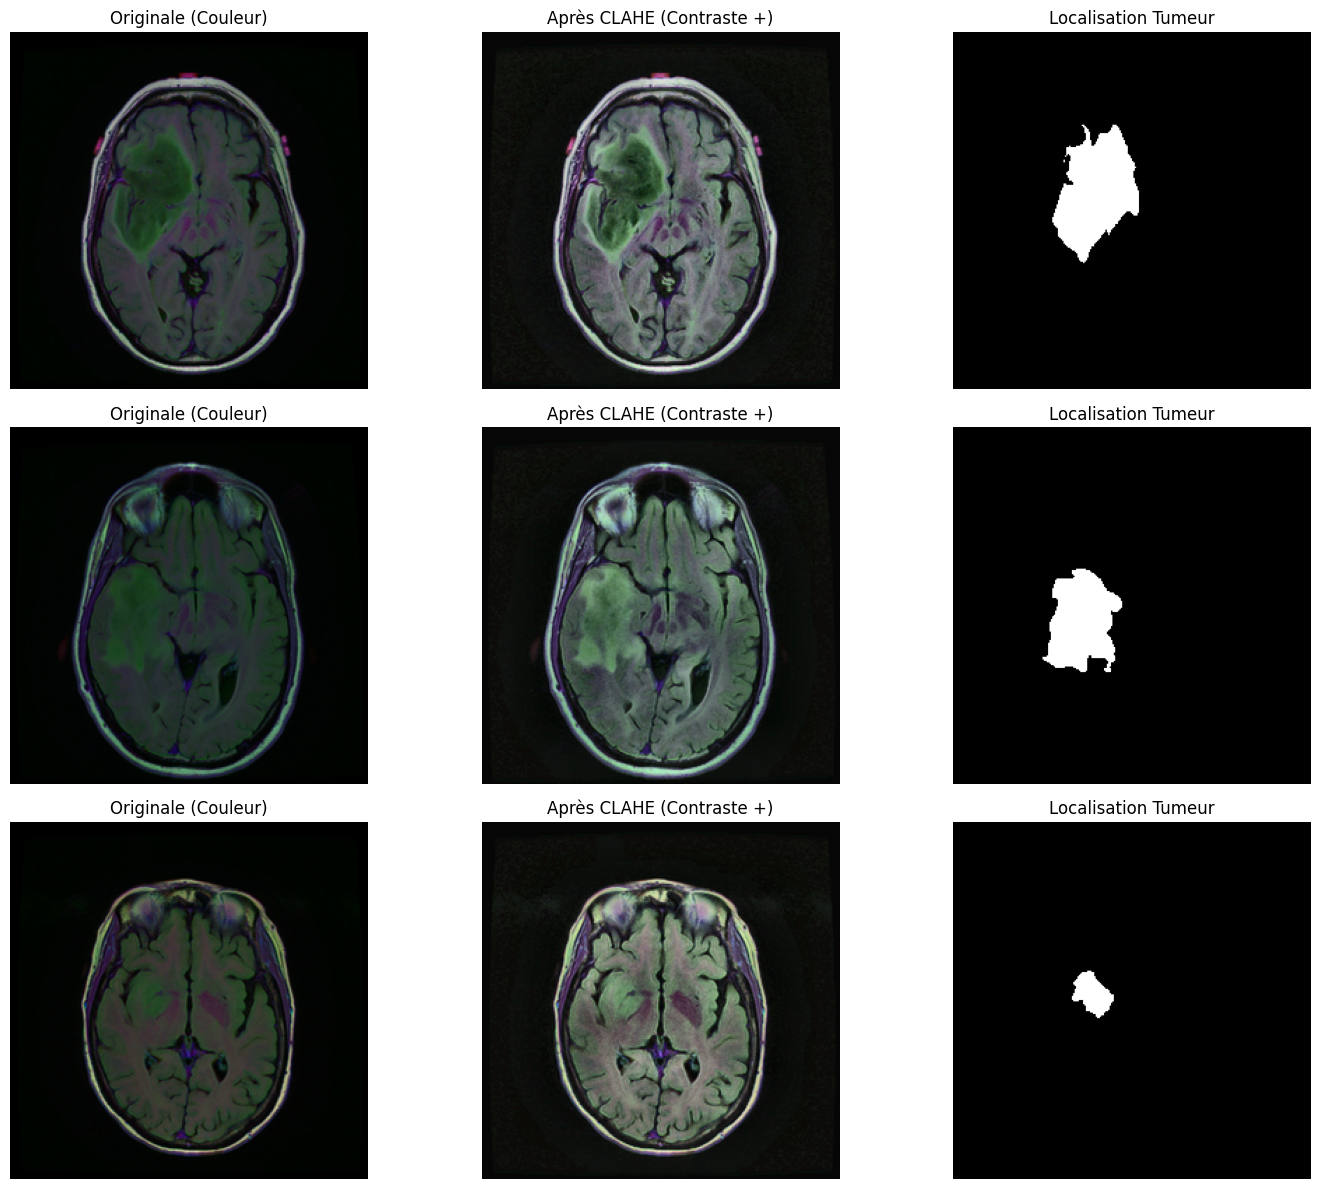

In [10]:
def apply_clahe_color(img):
    """
    Applique CLAHE en préservant les couleurs via l'espace LAB.
    """
    # 1. On convertit l'image BGR vers LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 2. On sépare les canaux (L = Luminosité, A et B = Couleurs)
    l, a, b = cv2.split(lab)

    # 3. On applique le CLAHE uniquement sur la Luminosité (L)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)

    # 4. On recolle les morceaux (Le L boosté + les A et B d'origine)
    lab_enhanced = cv2.merge((l2, a, b))

    # 5. On reconvertit en BGR pour l'affichage/utilisation
    enhanced_img = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    return enhanced_img

def visualize_contrast_enhancement(df, n_samples=3):
    plt.figure(figsize=(15, n_samples * 4))

    # Choix aléatoire d'images AVEC tumeur
    tumor_df = df[df['has_tumor'] == 1]
    indices = random.sample(range(len(tumor_df)), n_samples)

    for i, idx in enumerate(indices):
        img_path = tumor_df.iloc[idx]['image_path']
        mask_path = tumor_df.iloc[idx]['mask_path']

        # Lecture
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Application du CLAHE (Version couleur LAB)
        enhanced = apply_clahe_color(img)

        # --- AFFICHAGE ---

        # 1. Image Originale (EN COULEUR)
        plt.subplot(n_samples, 3, i*3 + 1)
        # Conversion BGR -> RGB pour que Matplotlib affiche les bonnes couleurs
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title("Originale (Couleur)")
        plt.axis('off')

        # 2. Image Améliorée (EN COULEUR)
        plt.subplot(n_samples, 3, i*3 + 2)
        # Conversion BGR -> RGB aussi pour l'image améliorée
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        plt.imshow(enhanced_rgb)
        plt.title("Après CLAHE (Contraste +)")
        plt.axis('off')

        # 3. Masque
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Localisation Tumeur")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# --- Lancement du test ---
# On suppose que 'df_final' (ton dataframe équilibré) est toujours en mémoire
# Si tu l'as perdu, relance d'abord la création du dataframe
visualize_contrast_enhancement(df_final, n_samples=3)

## Metrics

In [11]:
# --- 1. DÉFINITION DES MÉTRIQUES (DICE) ---
def dice_coef(y_true, y_pred):
    # On aplatit les images pour comparer pixel par pixel
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    # Formule du Dice : (2 * Intersection) / (Total pixels prédits + Total pixels réels)
    # Le smooth=1 évite la division par zéro
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## Ploting results

### Plot History Function

In [12]:
def plot_history(history, title="Baseline Model Performance"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Graphique de la LOSS (Erreur)
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss (Plus bas est mieux)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Dice Loss')
    ax1.legend()
    ax1.grid(True)

    # Graphique du DICE SCORE (Précision)
    ax2.plot(history.history['dice_coef'], label='Train Dice')
    ax2.plot(history.history['val_dice_coef'], label='Validation Dice')
    ax2.set_title(f'{title} - Dice Score (Plus haut est mieux)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Dice Coefficient')
    ax2.legend()
    ax2.grid(True)

    plt.show()

### Predict Function

In [13]:
def predict_and_plot(model, df, n_samples=3):
    """
    Prend le modèle, le dataframe de test, et affiche n prédictions.
    """
    plt.figure(figsize=(15, n_samples * 4))

    # On choisit des indices au hasard dans le dataset de TEST
    # (Important : on ne teste pas sur ce qu'il a déjà appris !)
    indices = random.sample(range(len(df)), n_samples)

    for i, idx in enumerate(indices):
        # 1. Récupération des chemins
        img_path = df.iloc[idx]['image_path']
        mask_path = df.iloc[idx]['mask_path']

        # 2. Préparation de l'Image (Input)
        # Lecture + Resize + Normalisation
        img_raw = cv2.imread(img_path)
        img_input = cv2.resize(img_raw, (256, 256))
        img_input = img_input / 255.0 # Normalisation 0-1

        # Le modèle attend un batch (1, 256, 256, 3), pas juste (256, 256, 3)
        img_batch = np.expand_dims(img_input, axis=0)

        # 3. PRÉDICTION (.predict se fait ici !)
        pred_mask = model.predict(img_batch, verbose=0)

        # 4. Post-traitement
        # La sortie est une probabilité (ex: 0.8). On coupe à 0.5 pour avoir 0 ou 1.
        pred_mask = (pred_mask > 0.5).astype(np.uint8)
        # On retire la dimension du batch pour l'affichage (256, 256)
        pred_mask = np.squeeze(pred_mask)

        # Lecture du Vrai Masque pour comparer
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, (256, 256))

        # --- AFFICHAGE ---
        # Colonne 1 : Image Originale
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
        plt.title(f"Radio Originale (Patient {idx})")
        plt.axis('off')

        # Colonne 2 : Vrai Masque (Ce qu'on attendait)
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Vérité Terrain (Cible)")
        plt.axis('off')

        # Colonne 3 : Prédiction (Ce que l'IA a vu)
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Prédiction IA")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Simple U-Net

### Architecture

In [14]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # --- ENCODEUR (La Descente) ---
    # On garde 4 niveaux pour la complexité, mais on contrôle les filtres.

    # Niveau 1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Niveau 2
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Niveau 3
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Niveau 4
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # --- BOTTLENECK OPTIMISÉ ---
    # Au lieu de 256, on met 160. C'est le secret pour rester autour de 1M.
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- DÉCODEUR (La Remontée) ---

    # Remontée Niveau 4
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Remontée Niveau 3
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Remontée Niveau 2
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Remontée Niveau 1
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Sortie (Masque binaire)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

print("✅ Modèle Optimisé (~1M params) défini !")
model = simple_unet_model(IMG_SIZE, IMG_SIZE, 3)
model.summary()

✅ Modèle Optimisé (~1M params) défini !
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                     

### Compile et Callbacks

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-3),
                         loss=dice_coef_loss,
                         metrics=['accuracy', dice_coef])

unet_callbacks = [
    # 1. EarlyStopping (Arrêt Précoce)
    # Patiente 10 pour laisser le temps au modèle de dépasser les petits plateaux.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),

    # 2. ReduceLROnPlateau (Ralentissement de l'apprentissage)
    # Si la perte stagne pendant 5 époques, on ralentit pour forcer l'ajustement fin.
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,           # Diviser le Learning Rate par 5
        patience=5,
        min_lr=1e-6,          # Vitesse minimale de sécurité
        verbose=1
    ),

    # 3. ModelCheckpoint (Sauvegarde du meilleur modèle)
    # Sauvegarde uniquement si le Dice Score de validation s'améliore.
    tf.keras.callbacks.ModelCheckpoint(
        'unet_final_best.keras',
        monitor='val_dice_coef',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

### Entraînement

🚀 Lancement du U-Net
Objectif : Dice Score > 0.80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.4576 - dice_coef: 0.1088 - loss: 0.8912
Epoch 1: val_dice_coef improved from -inf to 0.41394, saving model to unet_final_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 69s 431ms/step - accuracy: 0.4624 - dice_coef: 0.1110 - loss: 0.8890 - val_accuracy: 0.9863 - val_dice_coef: 0.4139 - val_loss: 0.5861 - learning_rate: 0.0010
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9853 - dice_coef: 0.4751 - loss: 0.5249
Epoch 2: val_dice_coef improved from 0.41394 to 0.50929, saving model to unet_final_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 312ms/step - accuracy: 0.9853 - dice_coef: 0.4756 - loss: 0.5244 - val_accuracy: 0.9873 - val_dice_coef: 0.5093 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9867 - dice_coef: 0.5541 - loss: 0.4459
Epoch 3: val_dice_coef improved from 0.50929 to 0.50938, saving model to unet_final_best.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 1

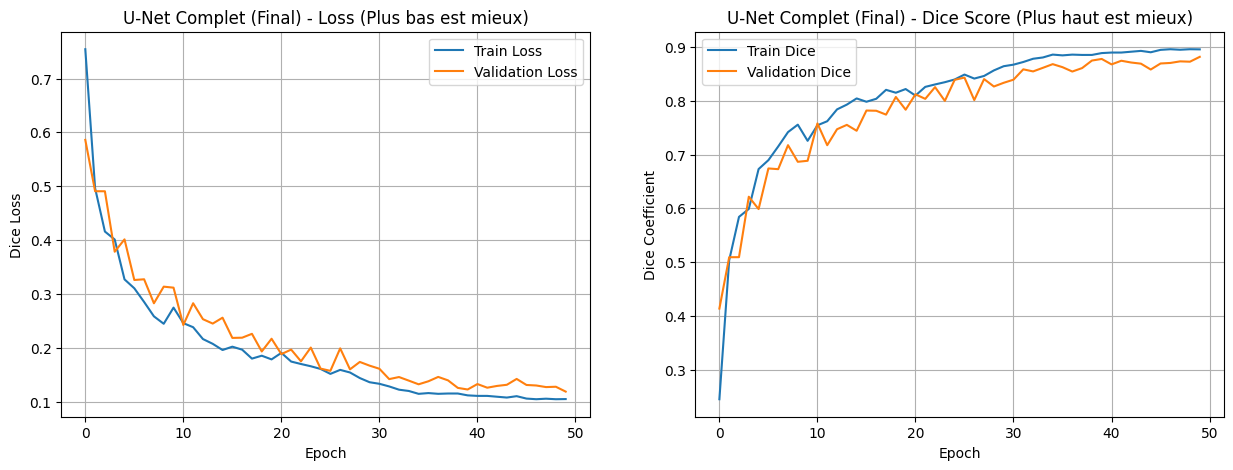

In [17]:
# 5. Entraînement
print("🚀 Lancement du U-Net")
print("Objectif : Dice Score > 0.80")

history_final = model.fit(
    train_gen_color,
    validation_data=val_gen_color,
    epochs=50, # On augmente car le modèle est plus gros
    callbacks=unet_callbacks,
    verbose=1
)

# 6. Affichage
plot_history(history_final, title="U-Net Complet (Final)")

### Résultat

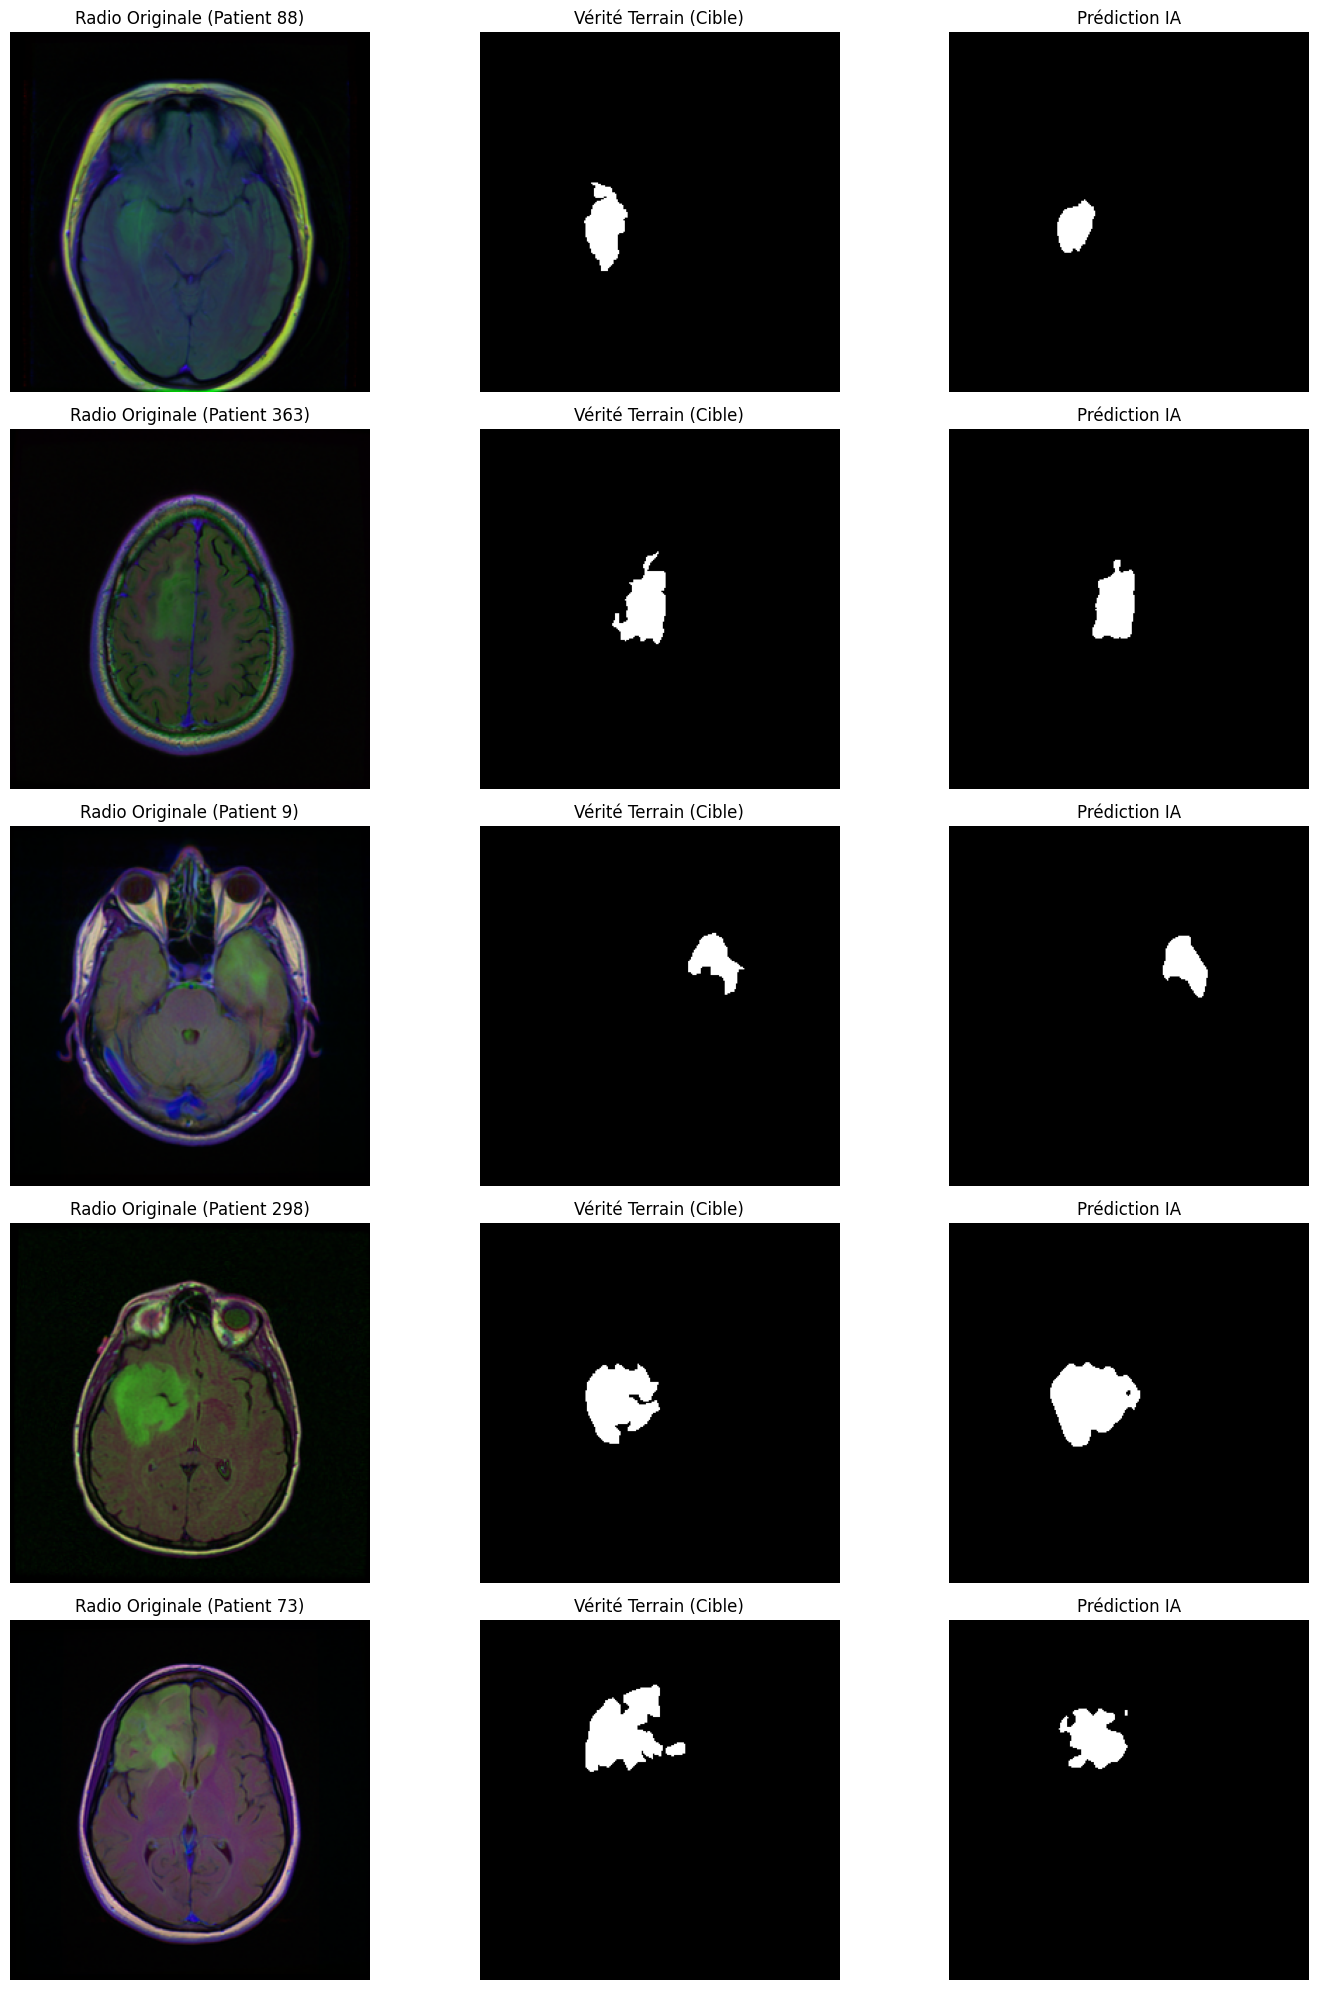

In [26]:
predict_and_plot(model, test_df, n_samples=5)

In [20]:
# Calcul du score Dice sur l'ensemble de test
# Le modèle a été compilé avec 'dice_coef' comme métrique
loss, accuracy, dice = model.evaluate(test_gen_color, verbose=1)

print(f"\nPerformance finale sur l'ensemble de test :")
print(f"  Loss (Dice Loss) : {loss:.4f}")
print(f"  Accuracy         : {accuracy:.4f}")
print(f"  Dice Coefficient : {dice:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.9956 - dice_coef: 0.8567 - loss: 0.1433

Performance finale sur l'ensemble de test :
  Loss (Dice Loss) : 0.1539
  Accuracy         : 0.9955
  Dice Coefficient : 0.8461
